# 0. Instalacja pakietu 

In [1]:
!pip install gymnasium


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import argparse
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output

# 1. Przestrzeń dyskretna

New best reward: -424 in episode 0
New best reward: -379 in episode 1
New best reward: -370 in episode 2
New best reward: -325 in episode 4
New best reward: -280 in episode 8
New best reward: -110 in episode 55
New best reward: -106 in episode 141
New best reward: -79 in episode 173
New best reward: -39 in episode 216
New best reward: -23 in episode 252
New best reward: -11 in episode 271
New best reward: 12 in episode 353
New best reward: 13 in episode 551
New best reward: 14 in episode 604
New best reward: 15 in episode 864
Q-tabela (fragment):
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.3470015   -3.42105457  -3.34406909  -3.35388135  -3.32458551
   -8.21229634]
 [ -2.25253401  -2.04379342  -2.26450682  -2.21415568   0.71432519
   -3.50429581]
 [ -2.94534901  -2.89897528  -2.8800535   -2.81085548  -2.61080142
   -6.90972913]
 [ -3.94226085  -3.89143796  -3.9288349   -3.87582927  -6.82062384
  -10.43649456]]


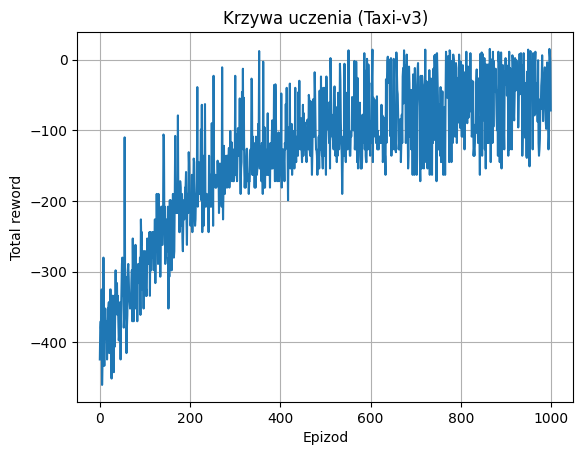

Najlepsza Q-tabela została zapisana do pliku taxi.pkl


In [3]:
env = gym.make("Taxi-v3")

# Parametry Q-learningu
num_states = env.observation_space.n
num_actions = env.action_space.n
q_table = np.zeros((num_states, num_actions))

alpha = 0.1        # Współczynnik uczenia
gamma = 0.9        # Współczynnik dyskontowy
epsilon = 1.0      # Początkowy współczynnik eksploracji
epsilon_min = 0.1
epsilon_decay = 0.995
num_episodes = 1000
max_steps = 100

# Do wykresu
rewards_all_episodes = []

# Dodatkowe zmienne do śledzenia najlepszego wyniku
best_reward = -np.inf

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_rewards = 0

    for _ in range(max_steps):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state, :])

        new_state, reward, done, truncated, info = env.step(action)

        q_table[state, action] = (1 - alpha) * q_table[state, action] + \
            alpha * (reward + gamma * np.max(q_table[new_state, :]))

        state = new_state
        total_rewards += reward

        if done:
            break

    # Zmniejszanie epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    rewards_all_episodes.append(total_rewards)

    # Sprawdzenie, czy to najlepszy wynik
    if total_rewards > best_reward:
        best_reward = total_rewards
        best_q_table = q_table.copy()  # Zapisanie najlepszej q_table
        print(f"New best reward: {best_reward} in episode {episode}")


env.close()

print("Q-tabela (fragment):")
print(q_table[:5])

# Krzywa uczenia
plt.plot(rewards_all_episodes)
plt.xlabel("Epizod")
plt.ylabel("Total reword")
plt.title("Krzywa uczenia (Taxi-v3)")
plt.grid()
plt.show()

# Zapisanie najlepszej Q-tabeli do pliku
with open("taxi.pkl", "wb") as f:
    pickle.dump(best_q_table, f)
print("Najlepsza Q-tabela została zapisana do pliku taxi.pkl")

# 2. Przestrzeń ciągła


In [4]:
import gymnasium as gym
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array", goal_velocity=0.1)  # default goal_velocity=0
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<Continuous_MountainCarEnv<MountainCarContinuous-v0>>>>>

In [5]:


def run(is_training=True, render=False, discount_factor=0.9, model_name=None):

    env = gym.make('MountainCarContinuous-v0', render_mode='human' if render else None)

    
    learning_rate_a = 0.9999       
    discount_factor_g = discount_factor      # gamma aka discount factor.
    epsilon = 1                  # start episilon at 1 (100% random actions)
    epsilon_decay_rate = 0.001   # epsilon decay rate
    epsilon_min = 0.05           # minimum epsilon
    pos_divisions = 20           # used to convert continuous state space to discrete space
    vel_divisions = 20           # used to convert continuous state space to discrete space
    act_divisions = 10           # used to convert continuous action space to discrete space
    num_episodes = 1200         # number of episodes to run
    max_steps = 5000            # max number of steps per episode
    # Divide position and velocity into segments
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], pos_divisions)    # Between -1.2 and 0.6
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], vel_divisions)    # Between -0.07 and 0.07

    # Divide action space into discrete segments
    act_space = np.linspace(env.action_space.low[0], env.action_space.high[0], act_divisions, endpoint=False)  # Between -1.0 and 1.0
    act_lookup_space =np.append(act_space, 1)

    if(is_training):
        q = np.zeros((len(pos_space)+1, len(vel_space)+1, len(act_space)+1)) # init a 21x21x11 array
    else:
        # Load q table
        model_name = f'mountain_car_cont_{discount_factor}_g.pkl' if model_name is None else model_name
        f = open(f'{model_name}', 'rb')
        q = pickle.load(f)
        f.close()


    best_reward = -999999        # track best reward
    best_mean_reward = -999999   # track best mean reward
    rewards_per_episode = []     # list to store rewards for each episode
    epsilon_history = []         # List to keep track of epsilon decay
    i = 0                        # episode counter

    while(i<=num_episodes):

        state = env.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)

        terminated = False          # True when reached goal
        rewards=0
        steps=0

        # Run episode until terminated or number of steps taken > 5000 (5000 is enough for the car to get to the goal randomly)
        while(not terminated and steps<=max_steps):

            if is_training and np.random.rand() < epsilon:
                # Choose random action
                action = env.action_space.sample()

                # Discretize action space
                action_idx = np.digitize(action, act_space)
            else:
                # Choose action with highest Q value
                action_idx = np.argmax(q[state_p, state_v, :])

                # Convert discrete action back to continuous
                action = act_lookup_space[action_idx]

            # Execute action
            new_state,reward,terminated,_,_ = env.step(np.array([action]))

            # Discretize new state space
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)

            if is_training:
                # Update Q table
                q[state_p, state_v, action_idx] = q[state_p, state_v, action_idx] + learning_rate_a * (
                    reward + discount_factor_g*np.max(q[new_state_p, new_state_v,:]) - q[state_p, state_v, action_idx]
                )

            # Update state
            state = new_state
            state_p = new_state_p
            state_v = new_state_v

            # Collect rewards
            rewards+=reward

            steps+=1

        # Track best reward
        if rewards > best_reward:
            best_reward = rewards

        # Store rewards per episode
        rewards_per_episode.append(rewards)

        # Print stats
        if is_training and i!=0 and i%100==0:
            # Calculate mean reward over the last 100 episodes
            mean_reward = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])
            print(f'Episode: {i}, Epsilon: {epsilon:0.2f}, Last Reward: {rewards:0.1f}, Best Reward: {best_reward:0.1f}, Mean Rewards {mean_reward:0.1f}')

            # Graph mean rewards
            mean_rewards = []
            for t in range(i):
                # Calculate mean reward over the t-100 episodes
                mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))

            plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
            plt.plot(mean_rewards)
            plt.xlabel('Episode')
            plt.ylabel('Mean Reward')
            plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
            plt.plot(epsilon_history)
            plt.xlabel('Episode')
            plt.ylabel('Epsilon')
            plt.savefig(f'mountain_car_cont_{discount_factor}.png')

            # Save Q table to file on new best reward
            if mean_reward>best_mean_reward:
                best_mean_reward = mean_reward
                print(f'Saving model on new best mean reward: {best_mean_reward:0.1f}')
                f = open(f'mountain_car_cont_{discount_factor}_g.pkl','wb')
                pickle.dump(q, f)
                f.close()

            # Stop, if solved
            # Lower the reward threshold since the mean reward might never get above the threshold
            if mean_reward>env.spec.reward_threshold:
                break

        elif not is_training:
            print(f'Episode: {i} Rewards: {rewards:0.1f}')



        # Decay epsilon
        epsilon = max(epsilon - epsilon_decay_rate, epsilon_min)
        epsilon_history.append(epsilon)

        # Increment episode counter
        i+=1

    env.close()




Training with discount factor: 0.8


C:\Users\serhi\AppData\Roaming\Python\Python312\site-packages\gymnasium\envs\classic_control\continuous_mountain_car.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward -= math.pow(action[0], 2) * 0.1
C:\Users\serhi\AppData\Roaming\Python\Python312\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Episode: 100, Epsilon: 0.90, Last Reward: -164.1, Best Reward: 41.0, Mean Rewards -150.3
Saving model on new best mean reward: -150.3
Episode: 200, Epsilon: 0.80, Last Reward: -162.8, Best Reward: 44.4, Mean Rewards -135.8
Saving model on new best mean reward: -135.8
Episode: 300, Epsilon: 0.70, Last Reward: -156.3, Best Reward: 62.4, Mean Rewards -129.6
Saving model on new best mean reward: -129.6
Episode: 400, Epsilon: 0.60, Last Reward: 28.9, Best Reward: 69.5, Mean Rewards -92.7
Saving model on new best mean reward: -92.7
Episode: 500, Epsilon: 0.50, Last Reward: 26.7, Best Reward: 78.2, Mean Rewards -49.2
Saving model on new best mean reward: -49.2
Episode: 600, Epsilon: 0.40, Last Reward: -9.7, Best Reward: 78.2, Mean Rewards -12.7
Saving model on new best mean reward: -12.7
Episode: 700, Epsilon: 0.30, Last Reward: 19.0, Best Reward: 89.0, Mean Rewards 35.0
Saving model on new best mean reward: 35.0
Episode: 800, Epsilon: 0.20, Last Reward: 33.1, Best Reward: 89.2, Mean Rewards 

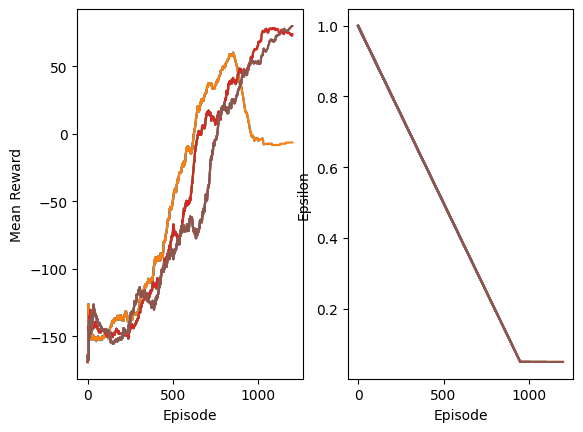

In [6]:
discount_factors = [0.8, 0.9, 0.99]
for d in discount_factors:
    print(f"Training with discount factor: {d}")
    run(is_training=True, render=False, discount_factor=d)

## 2.1 Kod do wizualizacji

In [7]:
# for d in discount_factors:
#     print(f"Testing with discount factor: {d}")
#     run(is_training=False, render=True, discount_factor=d)

In [8]:
# run(is_training=False, render=True, model_name='mountain_car_cont.pkl')

# 3. Własny algorytm